In [1]:
import numpy 
import random
import math
import time
import matplotlib.pyplot as plt

In [2]:
def calculate_mass(fit, min_flag):
    f_max, f_min = max(fit), min(fit)
    N = len(fit)
        
    if f_max == f_min:
        M = numpy.ones(N)
    
    else:
        if min_flag:
            best, worst = f_min, f_max  # Eq 17-18
        else:
            best, worst = f_max, f_min  # Eq 19-20
        
        M = (fit - worst) / (best - worst)  # Eq 15

    M_sum = sum(M)
    M /= M_sum  # Eq 16

    return M

In [3]:
def calculate_G(t, T):
    G0, alpha = 100, 20
    G = G0 * numpy.exp(-alpha * t / T)  # Eq 28
    return G

In [4]:
def calculate_G_field(X, M, G, t, T, Elitist_Check, R_power):
    (N, d) = X.shape
    
    # In the last iteration, only 2 percent of agents apply force to the others
    final_per = 2

    if Elitist_Check == 1:
        k_best = final_per + (1 - t / T) * (100 - final_per)
        k_best = int(round(N * k_best / 100))
    else:
        k_best = N

    ds = sorted(range(N), key=lambda k: M[k], reverse=True)

    E = numpy.zeros((N, d))

    for i in range(N):
        for ii in range(k_best):
            j = ds[ii]
            if i != j:
                # Euclidian distance
                R = numpy.linalg.norm(X[j,:] - X[i,:])

                rand = numpy.random.uniform()
                # Note that Mp(i) / Mi(i) = 1
                E[i] += rand * M[j] * (X[j] - X[i]) / (R ** R_power + numpy.finfo(float).eps)

    a = E * G
    return a

In [5]:
def move(X, v, a):
    N, dim = X.shape
    rand = numpy.random.uniform(0, 1, (N, dim))
    v = rand * v + a  # Eq 11
    X = X = v  # Eq 12

    return X, v

In [6]:
def space_bound(X, lb, ub):
    N, dim = X.shape
    for i in range(N):
        # agents that go out of the search space are reinitialized randomly
        Tp = X[i,:] > ub
        Tm = X[i,:] < lb
        X[i,:] = (X[i,:] * (~(Tp+Tm))) + ((numpy.random.rand(1, dim) * (ub-lb) + lb) * (Tp+Tm))
        
        # agents that go out of the search space are returned to the boundaries
        # Tp = X[i,:] > up
        # Tm = X[i,:] < low
        # X[i,:] = (X[i,:] * (~(Tp+Tm))) + (up * Tp) + (low * Tm)
        
    return X

In [7]:
class Solution:
    def __init__(self):
        self.optimizer = ""
        self.obj_fname = ""
        
        self.start_time = 0
        self.end_time = 0
        self.execution_time = 0

        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.pop_num = 0
        self.max_iters = 0

        self.best_score = 0
        self.best_individual = numpy.array([])
        self.best_so_far = numpy.array([])

In [8]:
def F1(x):
    return numpy.sum(x**2)

def F2(x):
    return numpy.sum(abs(x)) + numpy.prod(abs(x))

def get_fn_details(fn):
    """ [function, min_flag, lb, ub, dim] """
    param = {
        "F1": [F1, True, -100, 100, 30],
        "F2": [F2, True, -10, 10, 30],
    }
    return param.get(fn, "nothing")

In [9]:
def GSA(fn_name, N, max_it):
    # GSA parameters
    Elitist_Check = 1
    R_power = 1
    
    [obj_fn, min_flag, lb, ub, d] = get_fn_details(fn_name)

    s = Solution()

    timer_start = time.time()
    print(f"GSA is optimizing \"{obj_fn.__name__}\"")

    s.optimizer = "GSA"
    s.obj_fname = obj_fn.__name__
    s.start_time = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.lb = lb
    s.ub = ub
    s.dim = d
    s.pop_num = N
    s.max_iters = max_it

    s.best_so_far = numpy.zeros(max_it)

    """ 1. Generate Initial Population """
    # Initial position of all agents
    X = numpy.random.uniform(0, 1, (N, d)) * (ub - lb) + lb

    # Initial velocity of all agents
    v = numpy.zeros((N, d))

    # Initial fitness value and mass of all agents
    fit = numpy.zeros(N)
    M = numpy.zeros(N)
    
    for t in range(max_it):
        # Checking that all agents are within allowable range
        X = space_bound(X, lb, ub)

        """ 2.  Evaluate the fitness for each agent """
        for i in range(N):
            fit[i] = obj_fn(X[i])

        """ 3. Update the value of "G" """        
        G = calculate_G(t, max_it)

        """ 4. Calculate "M" and "a" for each agent """
        M = calculate_mass(fit, min_flag)
        a = calculate_G_field(X, M, G, t, max_it, Elitist_Check, R_power)

        """ 5. Update velocity and position """
        X, v = move(X, v, a)

        # Add the best fitness score of the ith iteration to the "best_so_far" array
        s.best_so_far[t] = max(fit)
    
    
    # Keep track of the agent with the best fitness score
    best_agent = numpy.argmax(fit)
    s.best_individual = X[best_agent]
    s.best_score = fit[best_agent]
    
    timer_end = time.time()

    s.endTime = time.strftime("%Y-%m-%d-%H-%M-%S")
    s.execution_time = timer_end - timer_start

    return s

In [10]:
runs = 1

N = 50
max_it = 1000
fn_name = "F1"

best_across_runs = []

for k in range (0, runs):
    x = GSA(fn_name, N, max_it)
    best_across_runs.append(x.best_so_far)
    print(f"Average best-so-far: {x.best_score}")

GSA is optimizing "F1"
Average best-so-far: 3.2079323177253136e-17


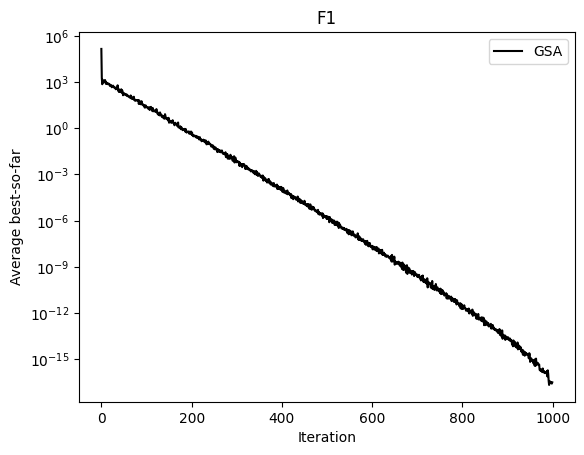

In [13]:
best_across_runs = numpy.array(best_across_runs)

# best_chart contains the best score for all iterations averaged across all runs
best_chart = []
for i in range(max_it):
    avg_best = sum(best_across_runs[:,i]) / len(best_across_runs[:,i])
    best_chart.append(avg_best)

# Plotting the convergence graph
plt.semilogy(best_chart, "-k")
plt.title(fn_name)
plt.xlabel('Iteration')
plt.ylabel('Average best-so-far')
plt.legend(['GSA'])
plt.show()